# Livrable 2

## 1. Introduction

Dans le cadre du projet Leyenda, dont l'objectif est de réaliser un modèle de DeepLearning permettant de faire du captionning, c'est à dire de créer un texte à partir d'une image. Ce livrable se concentre sur une étape cruciale du prétraitement des images : le débruitage. 

Le bruit numérique, qui peut résulter de diverses sources telles que des erreurs de capteurs ou des conditions de numérisation sous-optimales, affecte la qualité des images. Ce bruit altère les performances des algorithmes de traitement d'images en ajoutant des informations non désirées qui peuvent perturber l'analyse. Il est donc essentiel de débruiter ces images avant de les soumettre à d'autres algorithmes de classification ou de reconnaissance d'images.

Dans cette phase, nous utiliserons des **auto-encodeurs à convolution** pour réaliser un débruitage efficace. Ces réseaux de neurones profonds sont particulièrement adaptés au traitement d'images grâce à leur capacité à capturer les caractéristiques spatiales de l'image. Le notebook documente chaque étape du processus, depuis le chargement des images, jusqu'à leur traitement et l'évaluation des performances du modèle.


## 2. Importation et exploration des données

Avant de procéder au traitement des images, il est essentiel de configurer l'environnement en important les bibliothèques nécessaires. Cette section se concentre sur l'importation des modules et packages requis pour l'analyse et le traitement des images, ainsi que sur la configuration initiale. Nous importons également les données sous forme d'images, que nous explorerons avant d'entamer le processus de débruitage.

### 2.1. Code d'importation

In [2]:
import warnings, os, datetime, zipfile, tqdm, gdown, glob, pytz
import matplotlib.pyplot as plt
import tensorflow as tf

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### 2.2. Configuration des chemins et des paramètres

Dans cette section, nous configurons les chemins vers les répertoires de données et les modèles, ainsi que plusieurs paramètres essentiels pour l'entraînement du modèle.

In [3]:
timezone = pytz.timezone('Europe/Paris')
now = datetime.datetime.now(timezone).strftime('%Y.%m.%d-%H.%M.%S')

project_path = os.getcwd()

paths = {
    "data_path": f"{project_path}/data",
    "train_data_path": f"{project_path}/data/train",
    "model_path": f"{project_path}/models",
    "checkpoint_path": f"{project_path}/weights/model_early",
    "log_path": f"{project_path}/logs/fit/{now}_model"
}

for key, path in paths.items():
    os.makedirs(path, exist_ok=True)

image_h = 224
image_w = 224
batch_s = 32
ecpchs = 50

encoding_dim = 256

### 2.3. Téléchargement et extraction du dataset

Pour effectuer le traitement des images, il est nécessaire de télécharger et d'extraire le dataset. Le dataset est stocké dans un fichier compressé `.zip` disponible sur Google Drive. La fonction suivante télécharge ce dataset, si nécessaire, et l'extrait dans le répertoire approprié.

In [ ]:
def download_dataset(force=False):
    # Construct the dataset path
    dataset_path = os.path.join(paths['train_data_path'], 'dataset_livrable_2.zip')

    # Check if the dataset is already downloaded
    if os.path.exists(dataset_path) and not force:
        print("Dataset is already downloaded.")
    else:
        print("Downloading dataset...")
        url = 'https://drive.google.com/uc?export=download&id=190NL04KXMiUsnC-rdYDB9PLxCgk-MKuy'
        gdown.download(url, dataset_path, quiet=False)
    
    # Check if the dataset is already extracted
    if len(os.listdir(paths['train_data_path'])) >= 2 and not force:
        print("Dataset is already extracted.")
    else:
        print("Extracting dataset...")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            files = zip_ref.infolist()
            with tqdm.tqdm(total=len(files), desc="Extracting", unit="file") as pbar:
                for file in files:
                    zip_ref.extract(file, paths['train_data_path'])
                    pbar.update(1)
            print(f"Dataset extracted to {paths['train_data_path']}")
        
download_dataset()

### 2.4. Vérification de l'intégrité des images dans le dataset

Il est essentiel de s'assurer que les images du dataset sont valides avant de les utiliser pour l'entraînement d'un modèle. Cette section présente la fonction `check_images_in_dataset` qui permet de vérifier l'intégrité de chaque image et de supprimer les fichiers corrompus ou non valides.

In [ ]:
def check_images_in_dataset(dataset_path):
    # Get the paths of all image files (jpg, png, etc.)
    img_paths = glob.glob(os.path.join(dataset_path, '*/*.*'))

    for img_path in tqdm.tqdm(img_paths, desc="Checking images"):
        try:
            # Read and decode the image to check if it is valid
            img_bytes = tf.io.read_file(img_path)
            tf.io.decode_image(img_bytes)

        except tf.errors.InvalidArgumentError as e:
            # Catch specific TensorFlow error and remove bad files
            print(f"Found corrupt image: {img_path}. Error: {str(e)}. Removing it.")
            os.remove(img_path)
        except Exception as e:
            # General exception handler for other possible issues
            print(f"Error processing image: {img_path}. Error: {str(e)}. Removing it.")
            os.remove(img_path)

check_images_in_dataset(paths['train_data_path'])

### 2.5. Chargement et division des images en ensembles d'entraînement et de test

Dans cette section, nous chargeons les images du dataset et les divisons en deux sous-ensembles : l'un pour l'entraînement (80%) et l'autre pour la validation (20%). Cette étape est cruciale pour entraîner le modèle sur une partie des données tout en réservant une portion pour évaluer ses performances.

In [ ]:
# Load and split images into train and test sets (80%-20%)
train_set, validation_set = tf.keras.utils.image_dataset_from_directory(
    paths['train_data_path'],
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels=None,
    label_mode=None
)

### 2.6. Prétraitement des images : Ajout de bruit gaussien et redimensionnement

Dans cette phase, nous ajoutons une couche de redimensionnement pour normaliser les valeurs des pixels des images et appliquons un bruit gaussien à chaque lot d'images. Ce bruit simule des perturbations réelles présentes dans des images de mauvaise qualité, comme celles numérisées avec des artefacts, afin d'entraîner un modèle capable de restaurer des images bruitées.

In [7]:
# Adding the resizing layer
rescale_layer = tf.keras.layers.Rescaling(1./255)

# Adds Gaussian noise to images, keeping pixel values in [0, 1].
def add_gaussian_noise(images, min_noise=0.1, max_noise=0.5):
    batch_size = tf.shape(images)[0]
    noise_factor = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=min_noise, maxval=max_noise)
    noise = tf.random.normal(shape=tf.shape(images))
    noisy_images = images + noise_factor * noise
    noisy_images = tf.clip_by_value(noisy_images, 0.0, 1.0)
    return noisy_images

noisy_train_set = train_set.map(
    lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

noisy_validation_set = validation_set.map(
    lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### 2.7. Visualisation des images originales et bruitées

La visualisation est une étape importante pour s'assurer que le bruit est correctement appliqué aux images d'entraînement et pour comparer les images d'origine avec leurs versions bruitées. La fonction `display_noisy_train_images` permet d'afficher côte à côte un échantillon d'images originales et bruitées à partir du dataset d'entraînement.

In [ ]:
# Function for displaying original and noisy images
def display_noisy_train_images(noisy_dataset, num_images=5):
    plt.figure(figsize=(15, 6))

    for noisy_images, original_images in noisy_dataset.take(1):
        for i in range(num_images):
            # Original pictures
            plt.subplot(2, num_images, i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title('Original')
            plt.axis('off')

            # Noisy images
            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title('Noisy')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

display_noisy_train_images(noisy_train_set, num_images=5)

## 3. Construction de l'Auto-encodeur

Un auto-encodeur est un type de réseau de neurones utilisé pour apprendre une représentation compacte (encodée) des données en entrée. Il est constitué de deux parties principales : l'encodeur et le décodeur. L'encodeur réduit les dimensions des données d'entrée, tandis que le décodeur tente de reconstruire les données originales à partir de cette représentation réduite. Ce modèle est particulièrement utile pour des tâches comme le débruitage d'images.

### Explication générale : Comment fonctionne un auto-encodeur ?

Un auto-encodeur prend une image en entrée et passe par plusieurs couches pour compresser l'image en une représentation latente plus petite. Ensuite, cette représentation compressée est passée à travers le décodeur, qui reconstruit l'image. L'objectif du modèle est de minimiser la différence entre l'image d'origine et l'image reconstruite, ce qui signifie qu'il apprend à capturer les caractéristiques importantes de l'image tout en éliminant le bruit ou d'autres détails inutiles.

Le modèle d'auto-encodeur est optimisé avec une fonction de perte telle que l'erreur quadratique moyenne (MSE) pour comparer les pixels de l'image originale à ceux de l'image reconstruite.

### 3.1. Construction de l'Auto-encodeur

In [9]:
# def build_autoencoder(input_shape):
#     input_img = tf.keras.layers.Input(shape=input_shape)
    
#     # Encoder
#     x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
#     x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

#     x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

#     x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
#     encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

#     # Decoder
#     x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
#     x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
#     x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#     x = tf.keras.layers.UpSampling2D((2, 2))(x)

#     x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#     x = tf.keras.layers.UpSampling2D((2, 2))(x)

#     decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
#     # Self-encoding model
#     autoencoder = tf.keras.Model(input_img, decoded)
#     return autoencoder

# # Model construction
# input_shape = (image_h, image_w, 3)
# autoencoder = build_autoencoder(input_shape)

# def psnr(y_true, y_pred):
#     return tf.image.psnr(y_true, y_pred, max_val=1.0)

# def ssim(y_true, y_pred):
#     return tf.image.ssim(y_true, y_pred, max_val=1.0)

# autoencoder.compile(optimizer='adam', loss='mse', metrics=[psnr, ssim])
# autoencoder.summary()

### 3.2. Explication du modèle couche par couche

#### 1. **Encodeur** 

L'encodeur est responsable de la compression des données d'entrée en une représentation plus compacte. Cela se fait à l'aide de couches convolutives et de pooling pour réduire les dimensions tout en capturant les caractéristiques importantes de l'image.

- **Première couche Conv2D :**
  - **Type de couche** : Convolution 2D
  - **Nombre de filtres** : 32 filtres
  - **Taille du noyau (kernel)** : (3, 3)
  - **Fonction d'activation** : ReLU
  - **Padding** : `same` (cela conserve les dimensions d'entrée)
  - **Rôle** : Appliquer 32 filtres de convolution pour extraire des caractéristiques basiques des images (bords, textures).

- **MaxPooling2D :**
  - **Type de couche** : Pooling (sous-échantillonnage)
  - **Taille du pool** : (2, 2)
  - **Padding** : `same` (cela conserve les dimensions tout en réduisant la résolution)
  - **Rôle** : Réduit la taille de l'image de moitié, en prenant la valeur maximale dans chaque fenêtre de 2x2 pixels, tout en préservant les caractéristiques les plus saillantes.

- **Deuxième couche Conv2D :**
  - **Nombre de filtres** : 64 filtres
  - **Taille du noyau** : (3, 3)
  - **Fonction d'activation** : ReLU
  - **Padding** : `same`
  - **Rôle** : Augmenter la profondeur des caractéristiques extraites avec 64 filtres, capturant ainsi des détails plus complexes.

- **MaxPooling2D :**
  - Identique à la première couche de MaxPooling2D, cette couche réduit encore la résolution tout en conservant les caractéristiques importantes.

- **Troisième couche Conv2D :**
  - **Nombre de filtres** : 128 filtres
  - **Taille du noyau** : (3, 3)
  - **Fonction d'activation** : ReLU
  - **Padding** : `same`
  - **Rôle** : Extraire des caractéristiques encore plus fines avec plus de filtres, capturant des structures détaillées de l'image.

- **MaxPooling2D (encoded layer)** :
  - Cette couche finale de MaxPooling dans l'encodeur réduit encore l'image pour obtenir la représentation encodée. C'est la sortie compressée de l'image, appelée "représentation latente". Elle a une dimension beaucoup plus petite, mais conserve les informations essentielles nécessaires à la reconstruction.

#### 2. **Décodeur**

Le décodeur est la partie qui prend la représentation encodée et tente de reconstruire l'image d'origine. Il utilise des couches convolutives et d'up-sampling pour restaurer les dimensions de l'image à partir de la représentation latente.

- **Première couche Conv2D :**
  - **Nombre de filtres** : 128 filtres
  - **Taille du noyau** : (3, 3)
  - **Fonction d'activation** : ReLU
  - **Padding** : `same`
  - **Rôle** : Commence le processus de reconstruction de l'image avec les mêmes caractéristiques extraites par la dernière couche de convolution de l'encodeur.

- **UpSampling2D :**
  - **Type de couche** : Upsampling (sur-échantillonnage)
  - **Taille de la fenêtre** : (2, 2)
  - **Rôle** : Double les dimensions de l'image à chaque étape pour restaurer la résolution originale, inversant l'effet de MaxPooling.

- **Deuxième couche Conv2D :**
  - Identique à la précédente, mais avec 64 filtres, réduisant progressivement la complexité des caractéristiques au fur et à mesure que l'on s'approche de l'image reconstruite.

- **UpSampling2D :**
  - Identique à la première couche d'UpSampling, elle augmente encore les dimensions de l'image.

- **Troisième couche Conv2D :**
  - **Nombre de filtres** : 32 filtres
  - **Taille du noyau** : (3, 3)
  - **Fonction d'activation** : ReLU
  - **Padding** : `same`
  - **Rôle** : Applique des filtres moins complexes pour affiner la reconstruction de l'image.

- **UpSampling2D :**
  - Effectue une dernière opération de sur-échantillonnage pour restaurer l'image à sa taille originale.

- **Dernière couche Conv2D :**
  - **Nombre de filtres** : 3 (correspondant aux 3 canaux de couleur RGB)
  - **Taille du noyau** : (3, 3)
  - **Fonction d'activation** : Sigmoïde
  - **Padding** : `same`
  - **Rôle** : Reconstituer les valeurs de pixels de l'image reconstruite dans l'intervalle [0, 1].

#### 3. **Compilation du modèle**

Une fois le modèle créé, il est compilé avec les paramètres suivants :
- **Optimiseur** : `adam` — Un optimiseur populaire basé sur la descente de gradient adaptative.
- **Fonction de perte** : `mean squared error (mse)` — Calcul la différence entre l'image originale et l'image reconstruite pixel par pixel.

Nous utilisons deux métriques pour évaluer la performance de l'auto-encodeur :
- **PSNR** (Peak Signal-to-Noise Ratio) : Cette métrique mesure la qualité de l'image reconstruite par rapport à l'image originale. Une valeur de PSNR plus élevée indique une meilleure reconstruction.
- **SSIM** (Structural Similarity Index) : Le SSIM est une métrique perceptuelle qui évalue la similarité structurale entre deux images. Elle est particulièrement utile pour juger de la qualité visuelle des images débruitées.


### 3.3. Configuration des callbacks pour l'entraînement du modèle

Les callbacks sont des outils puissants permettant de contrôler le processus d'entraînement d'un modèle. Ils permettent de sauvegarder les poids, de surveiller les métriques, d'arrêter l'entraînement en cas de stagnation, et d'enregistrer des informations pour une analyse ultérieure. La fonction get_callbacks configure trois callbacks principaux : la sauvegarde des checkpoints, l'intégration avec TensorBoard, et l'arrêt anticipé (early stopping).

In [10]:
def get_callbacks():
    # Create a callback that saves the model's weights at each epoch where validation loss improves
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=paths['checkpoint_path'] + "/weights-epoch-{epoch:02d}-{val_loss:.2f}.weights.h5",
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )

    # Create a TensorBoard callback to log training metrics, model graphs, and images for visualization
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=paths['log_path'],
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=0,
        embeddings_freq=0
    )

    # Set up early stopping to halt training if validation loss stops improving for a set number of epochs
    early_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=0
    )

    return [checkpoint_callback, tensorboard_callback, early_callback]



### 3.4. Entraînement du modèle
Cette étape vise à ajuster les poids du modèle pour optimiser la reconstruction d'images bruitées. 
Nous utiliserons la méthode fit pour entraîner le modèle sur `noisy_train_set` tout en validant ses performances sur `noisy_test_set`. 
Grâce aux callbacks configurés précédemment, nous garantirons un entraînement efficace, 
avec une surveillance des métriques et la sauvegarde des poids les plus performants.

In [11]:
# # Model training
# history = autoencoder.fit(
#     noisy_train_set,
#     epochs=ecpchs,
#     validation_data=noisy_validation_set,
#     callbacks=get_callbacks()
# )

Le code ci-dessus lance l'entraînement de l'auto-encodeur en utilisant la méthode ``fit``. Il entraîne le modèle sur l'ensemble d'entraînement, ``noisy_train_set``, composé d'images bruitées, afin que le modèle apprenne à reconstruire les images originales. L'entraînement se déroule sur 50 époques, ce qui représente le nombre d'itérations sur les données. Pour évaluer la performance du modèle pendant l'entraînement, l'ensemble de validation ``noisy_test_set`` est utilisé. De plus, des callbacks sont intégrés via la fonction ``get_callbacks()``, permettant de gérer le processus d'entraînement en sauvegardant les poids du modèle et en activant l'arrêt anticipé si nécessaire. En résumé, ce code permet d'entraîner le modèle tout en surveillant sa performance et en optimisant le processus.

### 3.5. Visualisation des courbes de perte
Les courbes de perte sont des graphiques représentant l'évolution de la fonction de perte au fil des époques pendant l'entraînement d'un modèle. Elles permettent d'évaluer la performance du modèle en comparant les pertes d'entraînement et de validation. Analyser ces courbes aide à identifier des problèmes tels que le surapprentissage, lorsque la perte d'entraînement diminue mais que la perte de validation commence à augmenter.

In [12]:
def plot_training_curves(history, metrics=['loss'], figsize=(10, 5)):
    plt.figure(figsize=figsize)
    
    for metric in metrics:
        train_metric = history.history.get(metric)
        val_metric = history.history.get(f'val_{metric}')
        
        if train_metric and val_metric:
            plt.plot(train_metric, label=f'Training {metric.capitalize()}')
            plt.plot(val_metric, label=f'Validation {metric.capitalize()}')
        else:
            print(f"Warning: Metric '{metric}' not found in history. Skipping.")

    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Training and Validation Metrics Evolution')
    plt.legend()
    plt.grid(True)
    plt.show()

# plot_training_curves(history, metrics=['loss', 'psnr', 'ssim'])


Le code trace les courbes de perte d'entraînement et de validation pour évaluer la performance du modèle au cours des époques. La courbe de perte d'entraînement, représentée par ``history.history['loss']``, montre comment le modèle s'adapte aux données d'entraînement, tandis que la courbe de perte de validation, représentée par ``history.history['val_loss']``, indique la capacité du modèle à généraliser sur des données invisibles. L'évolution de ces courbes permet de détecter des phénomènes tels que le surapprentissage, où la perte d'entraînement continue de diminuer alors que la perte de validation commence à augmenter. L'ajout d'étiquettes et de légendes facilite l'interprétation des résultats, permettant ainsi d'analyser la convergence et l'efficacité du modèle durant l'entraînement.


### 3.6. Visualisation des images débruitées
La visualisation des images débruitées permet de comparer visuellement les images bruitées, débruitées et originales. Cela aide à évaluer l'efficacité du modèle d'auto-encodeur dans la restauration des détails perdus en raison du bruit. En observant les résultats, on peut déterminer si le modèle parvient à conserver les caractéristiques importantes de l'image tout en éliminant le bruit indésirable.

In [13]:
def display_denoised_images(model, dataset, num_images=5):
    plt.figure(figsize=(15, 8))

    for noisy_images, original_images in dataset.take(1):
        # Predicting denoised pictures
        denoised_images = model.predict(noisy_images)
        
        for i in range(num_images):
            # Noisy images
            plt.subplot(3, num_images, i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title('Noisy')
            plt.axis('off')
            
            # Denoised images
            plt.subplot(3, num_images, num_images + i + 1)
            plt.imshow(denoised_images[i])
            plt.title('Denoised')
            plt.axis('off')
            
            # Original picture
            plt.subplot(3, num_images, 2 * num_images + i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title('Original')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Displaying results
# display_denoised_images(autoencoder, noisy_validation_set, num_images=5)

### 3.7. Plan d'expérience

In [ ]:
# Get tf version
print(tf.__version__)

In [15]:
import itertools
import pandas as pd

# Define the hyperparameters to test
num_filters_options = [
    [16, 32, 64],
    [32, 64, 128],
    [64, 128, 256],
    # Add other configurations if necessary
]

optimizers = [
    tf.keras.optimizers.Adam(learning_rate=0.001),
    tf.keras.optimizers.Adam(learning_rate=0.0001),
    # Add other optimizer instances
]

loss_functions = [
    'mse',
    'mae',
    # Add other loss functions or custom functions
]

In [16]:
# Function to build the autoencoder with variable hyperparameters
def build_autoencoder_test(input_shape, num_filters):
    input_img = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder
    x = tf.keras.layers.Conv2D(num_filters[0], (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = tf.keras.layers.Conv2D(num_filters[1], (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = tf.keras.layers.Conv2D(num_filters[2], (3, 3), activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = tf.keras.layers.Conv2D(num_filters[2], (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(num_filters[1], (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(num_filters[0], (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = tf.keras.Model(input_img, decoded)
    return autoencoder

In [18]:
# Metric functions
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

# Create combinations of hyperparameters
experiments = list(itertools.product(num_filters_options, optimizers, loss_functions))

# List to store results
results = []

# Loop over each combination of hyperparameters
for num_filters, optimizer_instance, loss_function in experiments:
    optimizer_class = type(optimizer_instance)
    optimizer_config = optimizer_instance.get_config()
    print(f"Training with num_filters={num_filters}, optimizer={optimizer_class.__name__}, loss_function={loss_function}")
    
    # Build the model
    autoencoder = build_autoencoder_test((image_h, image_w, 3), num_filters)
    
    # Create a new optimizer instance
    optimizer = optimizer_class.from_config(optimizer_config)
    
    # Compile the model
    autoencoder.compile(optimizer=optimizer, loss=loss_function, metrics=[psnr_metric, ssim_metric])
    
    # Train the model
    history = autoencoder.fit(
        noisy_train_set,
        epochs=1, 
        validation_data=noisy_validation_set,
        callbacks=get_callbacks(),
        verbose=1
    )

    # Extraction des métriques finales
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    train_psnr = history.history['psnr_metric'][-1]
    val_psnr = history.history['val_psnr_metric'][-1]
    train_ssim = history.history['ssim_metric'][-1]
    val_ssim = history.history['val_ssim_metric'][-1]
    
    # Stockage des résultats
    results.append({
        'num_filters': num_filters,
        'optimizer': optimizer_class.__name__,
        'loss_function': loss_function,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_psnr': train_psnr,
        'val_psnr': val_psnr,
        'train_ssim': train_ssim,
        'val_ssim': val_ssim
    })

Training with num_filters=[16, 32, 64], optimizer=Adam, loss_function=mse
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 907ms/step - loss: 0.0836 - psnr_metric: 11.1363 - ssim_metric: 0.2940
Epoch 1: val_loss improved from inf to 0.06374, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_2/weights/model_early/weights-epoch-01-0.06.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0831 - psnr_metric: 11.1663 - ssim_metric: 0.2937 - val_loss: 0.0637 - val_psnr_metric: 12.3454 - val_ssim_metric: 0.3055
Training with num_filters=[16, 32, 64], optimizer=Adam, loss_function=mae
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - loss: 0.2531 - psnr_metric: 10.9885 - ssim_metric: 0.2935
Epoch 1: val_loss improved from inf to 0.25082, saving model to /Users/mohamed/Documents/FISE A5/z/livrable_2/weights/model_early/weights-epoch-01-0.25.weights.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.2528 - psnr_metric: 10.9997 - ssim_metric: 0.2929 - val_loss: 0.2508 - val_psnr_metric: 11.0447 - val_ssim_metric

In [19]:
results_df = pd.DataFrame(results)

sorted_by_val_loss = results_df.sort_values(by='val_loss')
print(sorted_by_val_loss)

best_psnr = results_df.sort_values(by='val_psnr', ascending=False)
print(best_psnr.head())

best_ssim = results_df.sort_values(by='val_ssim', ascending=False)
print(best_ssim.head())

       num_filters optimizer loss_function  train_loss  val_loss  train_psnr  \
4    [32, 64, 128]      Adam           mse    0.071849  0.050303   11.861339   
0     [16, 32, 64]      Adam           mse    0.079066  0.063739   11.406028   
8   [64, 128, 256]      Adam           mse    0.072540  0.072039   11.903561   
10  [64, 128, 256]      Adam           mse    0.081054  0.077182   11.288751   
6    [32, 64, 128]      Adam           mse    0.083777  0.083966   11.148528   
2     [16, 32, 64]      Adam           mse    0.084807  0.085522   11.093297   
5    [32, 64, 128]      Adam           mae    0.232401  0.203752   11.650776   
9   [64, 128, 256]      Adam           mae    0.240753  0.230988   11.341105   
11  [64, 128, 256]      Adam           mae    0.246452  0.240845   11.229059   
7    [32, 64, 128]      Adam           mae    0.247853  0.247942   11.178325   
1     [16, 32, 64]      Adam           mae    0.250303  0.250817   11.089448   
3     [16, 32, 64]      Adam           m

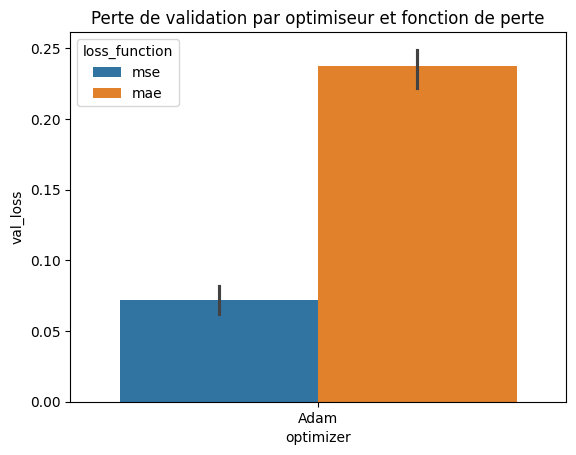

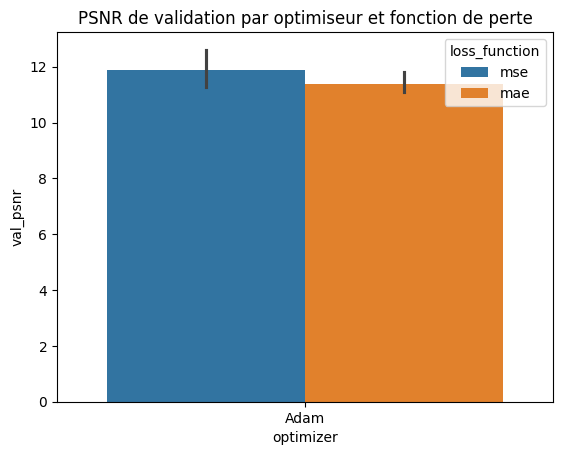

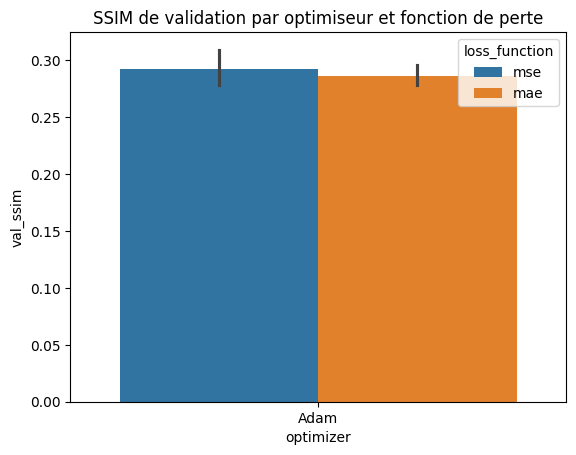

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='optimizer', y='val_loss', hue='loss_function', data=results_df)
plt.title('Perte de validation par optimiseur et fonction de perte')
plt.show()

sns.barplot(x='optimizer', y='val_psnr', hue='loss_function', data=results_df)
plt.title('PSNR de validation par optimiseur et fonction de perte')
plt.show()

sns.barplot(x='optimizer', y='val_ssim', hue='loss_function', data=results_df)
plt.title('SSIM de validation par optimiseur et fonction de perte')
plt.show()

### 4. Conclusion
Le projet Leyenda vise à développer une solution pour améliorer la qualité des images numérisées, facilitant ainsi leur traitement par des algorithmes de Deep Learning. L'accent est mis sur le débruitage, une étape essentielle du prétraitement, qui permet de réduire le bruit numérique résultant de divers facteurs tels que les erreurs de capteurs ou des conditions de numérisation inadaptées.

Pour atteindre cet objectif, des auto-encodeurs à convolution sont utilisés, exploitant leur capacité à capturer les caractéristiques spatiales des images tout en éliminant les informations non désirées. Le processus comprend plusieurs étapes clés, de l'importation et de l'exploration des données, à la vérification de l'intégrité des images, en passant par l'ajout de bruit gaussien pour simuler des conditions réelles.

La construction et l'entraînement d'un modèle d'auto-encodeur, optimisé à l'aide de la fonction de perte d'erreur quadratique moyenne, permettent de reconstruire des images de haute qualité à partir de leurs versions bruitées. Des callbacks sont configurés pour superviser l'entraînement et sauvegarder les meilleures performances, garantissant ainsi l'efficacité du modèle.

Les résultats de ce projet permettront d'améliorer significativement le traitement d'images par des algorithmes de classification et de reconnaissance, posant ainsi les bases pour des applications avancées dans divers domaines nécessitant une analyse d'images de qualité.

In [ ]:
import tensorflow as tf
import numpy as np

print("TensorFlow version:", tf.__version__)

# Données factices
x_train = np.random.rand(100, 64, 64, 3).astype(np.float32)
y_train = x_train.copy()

# Modèle simple
input_img = tf.keras.layers.Input(shape=(64, 64, 3))
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
decoded = tf.keras.layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
autoencoder = tf.keras.Model(input_img, decoded)

# Compilation du modèle avec une métrique intégrée
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

# Affichage des noms des métriques
print("Metrics names:", autoencoder.get_compile_config()['metrics'])

# Entraînement du modèle
autoencoder.fit(x_train, y_train, epochs=3, batch_size=10)

print("Metrics names:", autoencoder.get_metrics_result())

# Évaluation du modèle
eval_results = autoencoder.evaluate(x_train, y_train, verbose=0)
eval_dict = dict(zip(autoencoder.metrics_names, eval_results))
print("Evaluation results:", eval_dict)
